# Imbalanced Data Augmentation in NLP
* Notebook by Adam Lang
* Date: 7/26/2024

# Overview
* We will review imbalanced data augmentation techniques in NLP.

## Get the data

In [1]:
## import raw from github
import requests
from pathlib import Path #create file directory

# setup path to data folder
data_path = Path("data/")
file_path = data_path / "spam"

# if the folder doesn't exist, download and prepare
if file_path.is_dir():
  print(f"{file_path} directory already exists... skipping download")
else:
  print(f"{file_path} does not exist, creating one...")
  file_path.mkdir(parents=True, exist_ok=True)


# Download the data
with open(data_path / "spam.csv", "wb") as f:
  ## raw github or API link
  request = requests.get("https://raw.githubusercontent.com/theartificialguy/NLP-with-Deep-Learning/master/PREPROCESSING%20TECHNIQUES/SMSSpamCollection")
  print("Downloading dataset....")
  f.write(request.content) # write content of request to file

data/spam does not exist, creating one...


## Imports

In [2]:
import re
import string
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# nltk downloads
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# nltk imports
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

# sklearn imports
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Load Data

In [3]:
## set data_path
data_path = '/content/data/spam.csv'

## load data
df = pd.read_csv(data_path, sep='\t', header=None)

# shape of data
print(f"Data shape: {df.shape}")

# head of df
df.head()

Data shape: (5572, 2)


,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
## rename columns
df.rename(columns={0: 'label', 1: 'text'}, inplace=True)
# view result
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis - EDA

In [5]:
## check for target class imbalance
df['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

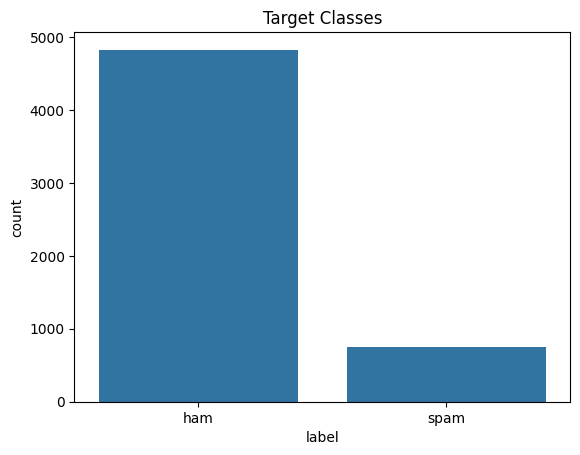

In [6]:
## plot this
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figsize=(12,8)
sns.countplot(x='label',data=df).set(title='Target Classes')
plt.show();

Summary:
* As we can see, we have significant class imbalance with more ham than spam targets.

In [7]:
## check for null values
df.isnull().sum()

label    0
text     0
dtype: int64

In [8]:
## calculating length of each text entry
df['length'] = df['text'].apply(lambda x: len(x))
df.head()

,label,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [9]:
df.describe()

,length
count,5572.000000
mean,80.489950
std,59.942907
min,2.000000
25%,36.000000
50%,62.000000
75%,122.000000
max,910.000000


## Text Preprocessing

In [10]:
## functions to preprocess text
def convert_to_lower(text):
  ## lower case
  return text.lower()


In [11]:
# remove numbers
def remove_numbers(text):
  num_pattern = r'\d+'
  without_num = re.sub(pattern=num_pattern, repl=" ", string=text)
  return without_num

In [12]:
# lemmatize text
def lemmatizing(text):
  # nltk lemmatizer
  lemmatizer = WordNetLemmatizer()
  tokens = word_tokenize(text)
  for i in range(len(tokens)):
    lemma_word = lemmatizer.lemmatize(tokens[i])
    tokens[i] = lemma_word
  return " ".join(tokens)

In [13]:
# remove punctuations
def remove_punctuation(text):
  return text.translate(str.maketrans('', '', string.punctuation))


In [14]:
## remove stopwords
def remove_stopwords(text):
  removed = []
  stop_words = list(stopwords.words('english'))
  tokens = word_tokenize(text)
  for i in range(len(tokens)):
    if tokens[i] not in stop_words:
      removed.append(tokens[i])
  return " ".join(removed)

In [15]:
## remove extra white space
def remove_extra_white_spaces(text):
  single_char_pattern = r'\s+[a-zA-Z]\s+'
  without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
  return without_sc

In [16]:
## apply all to text columns
df['text'] = df['text'].apply(lambda x: convert_to_lower(x))

df['text'] = df['text'].apply(lambda x: remove_numbers(x))

df['text'] = df['text'].apply(lambda x: remove_punctuation(x))

df['text'] = df['text'].apply(lambda x: remove_stopwords(x))

df['text'] = df['text'].apply(lambda x: remove_extra_white_spaces(x))

df['text'] = df['text'].apply(lambda x: lemmatizing(x))




In [17]:
## re-calculate the length of text after processing/cleaning
df['length_after_cleaning'] = df['text'].apply(lambda x: len(x))
df.head()

,label,text,length,length_after_cleaning
0,ham,go jurong point crazy available bugis great wo...,111,78
1,ham,ok lar joking wif oni,29,21
2,spam,free entry wkly comp win fa cup final tkts st ...,155,101
3,ham,u dun say early hor c already say,49,33
4,ham,nah dont think go usf life around though,61,40


In [18]:
## check metrics of new length
df.describe()

,length,length_after_cleaning
count,5572.000000,5572.000000
mean,80.489950,50.209261
std,59.942907,38.259443
min,2.000000,0.000000
25%,36.000000,22.000000
50%,62.000000,38.000000
75%,122.000000,74.000000
max,910.000000,513.000000


Summary:
* We can see overall the length went down significantly after cleaning.

#### Create Target Label Mapping

In [19]:
# target class label map
label_map = {
    'ham': 0,
    'spam': 1,
}

# apply label_map
df['label'] = df['label'].map(label_map)
df.head()

,label,text,length,length_after_cleaning
0,0,go jurong point crazy available bugis great wo...,111,78
1,0,ok lar joking wif oni,29,21
2,1,free entry wkly comp win fa cup final tkts st ...,155,101
3,0,u dun say early hor c already say,49,33
4,0,nah dont think go usf life around though,61,40


In [20]:
## check values of target class
df.label.value_counts()

label
0    4825
1     747
Name: count, dtype: int64

Summary:
* All set, we changed the labels to numbers.

## Vectorizing Text
* Using `TfidfVectorizer`
* Apply this without balancing the target class (yet).

In [21]:
## define vectorizer
tf_without_balancing = TfidfVectorizer()

# fit_transform vectorizer
X_tf_wob = tf_without_balancing.fit_transform(df['text'])

# toarray()
X_tf_wob = X_tf_wob.toarray()

In [22]:
## view the output
X_tf_wob.shape

(5572, 7906)

In [23]:
## view an index
X_tf_wob[0:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Summary:
* Now we can see we have converted each row of text into a sparse matrix.

## Feature Engineering - without balancing target class
* Split data into train_test_split

In [24]:
## train_test_split
X_train_tf_wob, X_test_tf_wob, y_train_tf_wob, y_test_tf_wob = train_test_split(X_tf_wob, df['label'].values, test_size=0.2)

In [25]:
## lets check the shapes
print(f"Shape of X_train_tf_wob {X_train_tf_wob.shape}")
print(f"Shape of X_test_tf_wob {X_test_tf_wob.shape}")
print(f"Shape of y_train_tf_wob {y_train_tf_wob.shape}")
print(f"Shape of y_test_tf_wob {y_test_tf_wob.shape}")

Shape of X_train_tf_wob (4457, 7906)
Shape of X_test_tf_wob (1115, 7906)
Shape of y_train_tf_wob (4457,)
Shape of y_test_tf_wob (1115,)


## Build Naive Bayes Classifier - without balancing

In [26]:
## instantiate NB classifier
nb = GaussianNB()

# fit model
nb.fit(X_train_tf_wob, y_train_tf_wob)

GaussianNB()

## Predict and Evaluate without balancing

In [27]:
## predict without balancing
y_pred_tf_wob = nb.predict(X_test_tf_wob)

In [28]:
## accuracy - even though this will be inaccurate with imbalanced data
print(accuracy_score(y_test_tf_wob, y_pred_tf_wob))

0.8708520179372198


In [29]:
## classification without balancing
print("Classifcation Report Naive Bayes Model - Without balancing")
print(classification_report(y_test_tf_wob, y_pred_tf_wob))

Classifcation Report Naive Bayes Model - Without balancing
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       972
           1       0.50      0.85      0.63       143

    accuracy                           0.87      1115
   macro avg       0.74      0.86      0.78      1115
weighted avg       0.91      0.87      0.88      1115



Summary:
* The results makes sense because we know that the 0 class or "Ham" has significantly more values than the 1 or "Spam" class thus the model is overfitting on this and the prediction result is near perfect which is not truly accurate.
* Thus we need to deal with the target class imbalance.

# Data Augmentation Techniques
* Now we will go over a few ways to handle the target class imbalance.

These are the 2 methods we will use:
1. BERT model (via transformers)
2. nlpaug
   * Specific library for dealing with NLP data augmentation: https://github.com/makcedward/nlpaug

In [30]:
## install libraries
!pip install transformers
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 11.3 MB/s eta 0:00:00


## nlpaug technique
* There are various augmenter models you can use, but below we will use `bert-base-uncased`.

In [31]:
## imports
import nlpaug.augmenter.word.context_word_embs as aug

In [32]:
# setup augmenter
augmenter = aug.ContextualWordEmbsAug(model_path='bert-base-uncased', action='insert')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [33]:
## sample text to test augmenter
sample_text = df['text'].iloc[90]
sample_text

'yeah ‘ stand close tho ‘ catch something'

In [34]:
## we will create sentence augmentation off this example
augmented_sample_text = augmenter.augment(sample_text)

In [35]:
# output of augmentation
augmented_sample_text

['hell yeah ‘ just stand close tho ‘ catch onto something']

We can now use this to augment our dataset wrapped in a function.

In [36]:
## define a function to augment text data
def augmentData(df: pd.DataFrame,
                augmenter,
                repetitions=1,
                samples=200):

  # list to store augmented text
  augmented_texts = []
  # selecting only minority class samples
  spam_df = df[df['label'] == 1].reset_index(drop=True) # removes unnecessary index column
  # iterate over samples
  for i in tqdm(np.random.randint(0, len(spam_df), samples)):
    # generating 'n_samples' of augmented texts
    for _ in range(repetitions):
      augmented_text = augmenter.augment(spam_df['text'].iloc[i])
      augmented_texts.append(augmented_text)

  data = {
      'label': 1,
      'text': augmented_texts
  }
  aug_df = pd.DataFrame(data)
  df = shuffle(pd.concat([df,aug_df]).reset_index(drop=True))
  return df

In [37]:
## new_df - remove length cols
new_df = df.drop(labels=['length', 'length_after_cleaning'], axis=1)
new_df.head()

,label,text
0,0,go jurong point crazy available bugis great wo...
1,0,ok lar joking wif oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,u dun say early hor c already say
4,0,nah dont think go usf life around though


In [38]:
4825-747

4078

In [41]:
## create samples - due to time we will only create 200 as an example
aug_df = augmentData(new_df, augmenter, samples=200) #can change num of samples

  0%|          | 0/200 [00:00<?, ?it/s]

In [42]:
## lets see the result of 200 samples
aug_df['label'].value_counts()

label
0    4825
1     947
Name: count, dtype: int64

In [43]:
## compared to previous target class size
df['label'].value_counts()

label
0    4825
1     747
Name: count, dtype: int64

Summary:
* So we can see that you can increase the samples using this technique. Granted we only created 200 new synthetic samples, ideally we would want to create enough to balance the classes evenly which would require more time and using a GPU as it would take a while using this method.

## Re-building model on augmented dataset

In [44]:
X_train, _, y_train, _ = train_test_split(aug_df['text'], aug_df['label'].values, test_size=0.1)
_, X_test, _, y_test = train_test_split(df['text'], df['label'].values, test_size=0.5)

In [45]:
# Convert X_train to a Series of strings
X_train = X_train.apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

## create new TfidfVectorizer
tf_with_aug = TfidfVectorizer()
# fit vectorizer
X_train_tf = tf_with_aug.fit_transform(X_train)
# toarray()
X_train_tf = X_train_tf.toarray()

In [46]:
# check shape
print(f"Shape of X_train_tf: {X_train_tf.shape}")

Shape of X_train_tf: (5194, 7691)


In [47]:
# view matrix
X_train_tf[0:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [48]:
## re-create Naive Bayes Classifier with augmented data experiment
nb = GaussianNB()
nb.fit(X_train_tf, y_train)

GaussianNB()

## Predict and Evaluate on Augmented Model

In [49]:
## transform
X_test_tf = tf_with_aug.transform(X_test)
X_test_tf = X_test_tf.toarray()

In [50]:
# predict
y_preds = nb.predict(X_test_tf)

In [51]:
# confusion matrix
print("Confusion Matrix for Augmented NB Model")
print(confusion_matrix(y_test,y_preds))
print()
# accuracy score
print("Accuracy Score for Augmented NB Model")
print(accuracy_score(y_test, y_preds))
print()
# classification report
print("Classification Report for Augmented NB Model")
print(classification_report(y_test, y_preds))
print()

Confusion Matrix for Augmented NB Model
[[2188  219]
 [   7  372]]

Accuracy Score for Augmented NB Model
0.9188801148600143

Classification Report for Augmented NB Model
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      2407
           1       0.63      0.98      0.77       379

    accuracy                           0.92      2786
   macro avg       0.81      0.95      0.86      2786
weighted avg       0.95      0.92      0.93      2786




# Summary
* By augmented the imbalanced target class (1 or spam) we were able to improve the following:
  * Precision: 0.50 --> 0.63
  * Recall: 0.85 --> 0.98
  * F1 score: 0.63 --> 0.77
* The overall accuracy of the model also improved from 87% to 92%. So even by upsampling by 200 samples we were able to improve the outcome of the model.
* It is also worth noting that other factors such as hyperparameter tuning may be worth considering (e.g. GridSearchCV).
* This method `nlpaug` may or may not be the best method as there are plenty of other techniques including SMOTE and sampling with replacement. However, this technique does allow use to use modern NLP techniques to slightly augment the text rather than just copy the exact samples by bootstrapping.
* It would be worth experimenting with other open source models that nlpaug has for augmentation.